# AirBnb New York - Web Scrpaing & Data Mining 
### Matthew Gazzano - Mattgazzano@gmail.com | https://www.linkedin.com/in/matthewgazzano/

### In this project, I aim to scrape listing data from New York AirBnb listings & output the data into a structured format for later querying and visualization

In [1]:
import pandas as pd
import numpy as np
import requests, re
from bs4 import BeautifulSoup

## Extract primary listing data from search results pages
### Airbnb limits the amount of visible listings of a particular searched area to 300. Every area is displayed in 15 webpages, each consisting of 20 listing per page. In this block of code, I extract the HTML code of each listing across all searched webpages.

In [2]:
# Identify subsections of New York city that we want to search for
neighborhood_codes = [
'Manhattan--New-York--NY--'
, 'Brooklyn--Brooklyn--NY--'
, 'Queens--Queens--NY--'
, 'Staten-Island--NY--'
, 'Bronx--NY--'
, 'Midtown--New-York--NY--'
, 'Upper-East-Side--New-York--NY--'
, 'Gramercy-Park--New-York--NY--'
, 'Chelsea--New-York--NY--'
, 'SoHo--New-York--NY--'
, 'Lower-East-Side--New-York--NY--'
, 'Financial-District--New-York--NY--'
, 'Lower-Manhattan--New-York--NY--'
, 'East-Village--New-York--NY--'
, 'Little-Italy--New-York--NY--'
, 'Chinatown--New-York--NY--'
, 'Harlem--New-York--NY--']

offset_qty = 0

# Compile a list urls with paginiation. Airbnb uses the added string 'items_offset' to the url to denote
# which of the 15 pages a user is looking at. It upticks in intervals of 20 (because there are 20 listings on a page)
urls = []
for j in range(0,15):
    for i in neighborhood_codes:
        urls.append('https://www.airbnb.com/s/'+i+'United-States/homes?items_offset='+str(offset_qty*20))
    offset_qty = offset_qty + 1

# Extract the HTML code from each url
soups = []
for i in urls:
    soups.append(BeautifulSoup(requests.get(i).content,'html.parser'))

# Extract the HTML code from each listing of each url
listing_soups = []
for i in soups:
    listing_soups.append(i.find_all('div','_8ssblpx'))

## In the last loop from the above cell, the HTML code from each listing is stored inside of a 2D list, which can be visualized the following way:

[ [ 1.1_html, 1.2_html, 1.3_html, 1.4_html, 1.5_html], 1.6_html, 1.7_html, 1.8_html, 1.9_html, 1.10_html, 1.11_html, 1.12_html, 1.13_html, 1.14_html, 1.15_html, 1.16_html, 1.17_html,1.18_html,1.19_html, 1.20_html], [2.1_html ......... ] ]

## So we need to use a nested loop to extract the textual data from each listing of each search page into a dictionary. This will include the following elements:
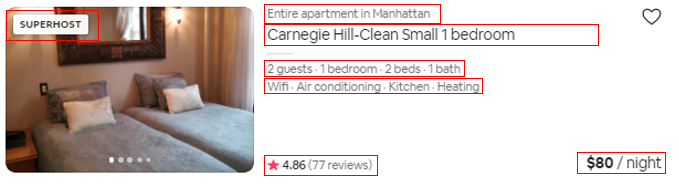

## Using the BeautifulSoup library, each textual element from the listing can be extracted using their HTML class.

## We should also note that some inputs from the listing may be omitted & as a result their HTML elements will not exist. This would cause an error in our loop. To account for this, I am using error handling to define variable values and replace non-existing HTML elements with null values in the dictionary.

In [3]:
airbnb = []
for k in range(len(listing_soups)):
    for i in range(len(listing_soups[k]))[:20]:
        try: listing_id = listing_soups[k][i].find('a').get('aria-labelledby').replace('title_','')
        except: listing_id = None
        try: listing_type = listing_soups[k][i].find('div', {'class': '_1tanv1h'}).get_text()
        except: listing_type = None
        try: name = listing_soups[k][i].find('div', {'class': '_5kaapu'}).get_text()
        except: name = None
        try: rooms = listing_soups[k][i].find('div', {'class': '_3c0zz1'}).get_text()
        except: rooms = None
        try: amenities = listing_soups[k][i].find_all("div",{"class":"_3c0zz1"})[1].get_text()
        except: amenities = None
        try: price = listing_soups[k][i].find('div', {'class': '_1gi6jw3f'}).get_text()
        except: price = None
        try: rating_reviews = listing_soups[k][i].find('div', {'class': '_h34mg6'}).get_text()
        except: rating_reviews = None
        try: superhost = True if listing_soups[k][i].find('div', {'class': '_1u0inz4'}).get_text() == 'SUPERHOST' else False
        except: superhost = False
        airbnb.append({'listing_id':listing_id,
                      'type': listing_type,
                      'name': name,
                      'rooms':rooms,
                      'amenities':amenities,
                      'price':price,
                      'rating_reviews':rating_reviews,
                      'superhost':superhost})

airbnb

[{'listing_id': '3585452',
  'type': 'Entire rental unit in Manhattan',
  'name': 'A Beautiful Brownstone Apartment',
  'rooms': '4 guests · Studio · 3 beds · 1 bath',
  'amenities': 'Wifi · Air conditioning · Kitchen · Heating',
  'price': '$91\xa0/ night',
  'rating_reviews': '4.76\xa0(339 reviews)$91\xa0/ night$91 per night',
  'superhost': True},
 {'listing_id': '45767160',
  'type': 'Entire rental unit in Chinatown',
  'name': 'Cozy apartment in the heart of Downtown Manhattan',
  'rooms': '3 guests · 2 bedrooms · 2 beds · 1 bath',
  'amenities': 'Wifi · Kitchen · Heating',
  'price': '$75\xa0/ night',
  'rating_reviews': '$75\xa0/ night$75 per night',
  'superhost': True},
 {'listing_id': '46756139',
  'type': 'Hotel room in South Street Seaport',
  'name': 'Perfect Extended Stay 21+ Days Hotel Room',
  'rooms': '2 guests · 1 bedroom · 1 bed · 1 private bath',
  'amenities': 'Wifi · Air conditioning · Heating',
  'price': '$84\xa0/ night',
  'rating_reviews': '$84\xa0/ night$84 p

## Now we will need to write the dictionary into a Pandas dataframe. Because of how the data was scraped, duplicate listings will exist- for example, listing xxx could have appeared on the webpage for Soho and Lower Manhattan since these subsections of NYC are close in proximity. So I will dedupe the dataframe by listing_id.
## While deduping the list, I found that the value of the 'type' column can vary depending on the webpage it was sourced from, with the default location being 'New York'
### For Example, listing_id 'xxx' may show up on the listing as 'Private Room in Upper West Side' on one search results page, and 'Private Room in New York' on another search results page.
### To account for this, I will sort the dataframe by a new column 'dedeupe_key', which assigns listings containing 'New York' the highest value. Then I sort the dataframe by this column in ascending order, dedupe the dataframe based on listing_id, and keep the first listing_id that appears.

In [4]:
#convert dictionary Into a Pandas dataframe
df_airbnb_ny = pd.DataFrame.from_dict(airbnb)

#Drop Rows with Blank Listing Data
df_airbnb_ny = df_airbnb_ny.dropna(axis=0, subset=['listing_id'])

# Remove listings that that have 'room types'
#when this termonology is in the 'rooms' variable,it relates to a hotel / motel, which will skew our data
df_airbnb_ny[~df_airbnb_ny.rooms.str.contains('room types')]                                              

# We only want to keep the entry labled with its subsection
# Sort the dataframe by type, moving 'New York' to the bottom, then dedupde the dataframe by listing ID
df_airbnb_ny['dedupe_key'] = np.where(df_airbnb_ny['type'].str.contains('New York'), 2, 1)
df_airbnb_ny.sort_values(by=['dedupe_key'])
df_airbnb_ny = df_airbnb_ny.drop_duplicates(subset=['listing_id'],keep='first')

#Set the listing_id column as the index of the dataframe
df_airbnb_ny = df_airbnb_ny.set_index('listing_id')

#Drop dedupe_key and display output
df_airbnb_ny = df_airbnb_ny.drop(columns = 'dedupe_key')
df_airbnb_ny.head()

,type,name,rooms,amenities,price,rating_reviews,superhost
listing_id,,,,,,,
3585452,Entire rental unit in Manhattan,A Beautiful Brownstone Apartment,4 guests · Studio · 3 beds · 1 bath,Wifi · Air conditioning · Kitchen · Heating,$91 / night,4.76 (339 reviews)$91 / night$91 per night,True
45767160,Entire rental unit in Chinatown,Cozy apartment in the heart of Downtown Manhattan,3 guests · 2 bedrooms · 2 beds · 1 bath,Wifi · Kitchen · Heating,$75 / night,$75 / night$75 per night,True
46756139,Hotel room in South Street Seaport,Perfect Extended Stay 21+ Days Hotel Room,2 guests · 1 bedroom · 1 bed · 1 private bath,Wifi · Air conditioning · Heating,$84 / night,$84 / night$84 per night,True
49705162,Entire rental unit in Soho,Modern and charming 1BR in the heart of SoHo,4 guests · 1 bedroom · 2 beds · 1 bath,Wifi · Air conditioning · Kitchen · Heating,$140 / night,$140 / night$140 per night,False
47996191,Entire rental unit in Manhattan,Furnished Studio in Little Italy,2 guests · Studio · 1 bed · 1 bath,Wifi · Air conditioning · Kitchen · Heating,$110 / night,$110 / night$110 per night,False


In [5]:
# # Write the dataframe to a csv file
# df_airbnb_ny.to_csv('df_airbnb_ny.csv')

# Extracting location data
## To get the latitude and longitude of each listing (for later data visualization through heat mapping), we will need to use a different method via the requests library and re (regular expression) module. These data points can be extracted using a regex function from a script tag found on the individual listing page.
## While running this loop, I found that some listings were temperamentally returning null latitude and longitude values, with results varying during each loop.
### To account for this, I reinstantiate the request function & reassign the latitude and longitude variables inside of a while loop until the value is not null.
### This is a time intensive process, so i am purposely running this block after the dataframe has been deduped to limit the number of iterations, and print out the enumerated results to show progress as it writes to a dictionary. I am also showing when the loop had to reinstantiate the request due to a null value, denoted by '(retry attempt)'
### My machine outputs this at a rate of ≈ .71 seconds per listing.

In [6]:
#Print and write to dictionary
airbnb_locations = []
listing_ids = df_airbnb_ny.index.to_list()
        
for count, i in enumerate(listing_ids, start=1):
    r = requests.get('https://www.airbnb.com/rooms/'+str(i))
    latitude = re.compile(r'"lat":([-0-9.]+),').findall(r.text)
    longitude = re.compile(r'"lng":([-0-9.]+),').findall(r.text)
    if latitude == [] or longitude == []:
        while latitude == [] or longitude == []:
            r = requests.get('https://www.airbnb.com/rooms/'+str(i))
            latitude = re.compile(r'"lat":([-0-9.]+),').findall(r.text)
            longitude = re.compile(r'"lng":([-0-9.]+),').findall(r.text)
            if latitude == [] or longitude ==[]:
                continue
            else:
                 airbnb_locations.append({
                'listing_id':i
                ,'latitude':latitude
                ,'longitude':longitude})
            print(count,'of '+str(len(listing_ids))+':',i,latitude,longitude)
    else:
        airbnb_locations.append({
        'listing_id':i
        ,'latitude':latitude
        ,'longitude':longitude})
        print(count,'of '+str(len(listing_ids))+':',i,latitude,longitude,' (retry attempt)')
             
airbnb_locations

1 of 2786: 3585452 ['40.80872'] ['-73.94124']
2 of 2786: 45767160 ['40.71394'] ['-73.99123']  (retry attempt)
3 of 2786: 46756139 ['40.70616'] ['-74.00379']
4 of 2786: 49705162 ['40.72371'] ['-74.0019']  (retry attempt)
5 of 2786: 47996191 ['40.72025'] ['-73.9938']
6 of 2786: 12317903 ['40.75307'] ['-73.96691']
7 of 2786: 45547297 ['40.76526'] ['-73.98867']
8 of 2786: 48131207 ['40.74328'] ['-73.98076']
9 of 2786: 25802121 ['40.76612'] ['-73.98273']  (retry attempt)
10 of 2786: 48253767 ['40.77467'] ['-73.91581']  (retry attempt)
11 of 2786: 42746488 ['40.73437'] ['-73.98728']
12 of 2786: 49362741 ['40.7976'] ['-73.96189']
13 of 2786: 45772997 ['40.76238'] ['-73.98917']
14 of 2786: 44337778 ['40.72861'] ['-73.98348']  (retry attempt)
15 of 2786: 50913661 ['40.74057'] ['-73.97755']
16 of 2786: 50197742 ['40.766'] ['-73.99453']  (retry attempt)
17 of 2786: 49409612 ['40.77796'] ['-73.96073']
18 of 2786: 49100116 ['40.75717'] ['-73.98347']  (retry attempt)
19 of 2786: 45988921 ['40.76454'

[{'listing_id': '3585452',
  'latitude': ['40.80872'],
  'longitude': ['-73.94124']},
 {'listing_id': '45767160',
  'latitude': ['40.71394'],
  'longitude': ['-73.99123']},
 {'listing_id': '46756139',
  'latitude': ['40.70616'],
  'longitude': ['-74.00379']},
 {'listing_id': '49705162',
  'latitude': ['40.72371'],
  'longitude': ['-74.0019']},
 {'listing_id': '47996191',
  'latitude': ['40.72025'],
  'longitude': ['-73.9938']},
 {'listing_id': '12317903',
  'latitude': ['40.75307'],
  'longitude': ['-73.96691']},
 {'listing_id': '45547297',
  'latitude': ['40.76526'],
  'longitude': ['-73.98867']},
 {'listing_id': '48131207',
  'latitude': ['40.74328'],
  'longitude': ['-73.98076']},
 {'listing_id': '25802121',
  'latitude': ['40.76612'],
  'longitude': ['-73.98273']},
 ...]

## Now we need to write the airbnb_location dictionary to a pandas dataframe, and join it to the df_airbnb_ny dataframe.

In [7]:
#Write to a dataframe
df_airbnb_locations = pd.DataFrame.from_dict(airbnb_locations)

#Drop bracket values on latitude and longitude
df_airbnb_locations['latitude'] = df_airbnb_locations['latitude'].str[0]
df_airbnb_locations['longitude'] = df_airbnb_locations['longitude'].str[0]

#Set the listing_id column as the index of the dataframe
df_airbnb_locations = df_airbnb_locations.set_index('listing_id')

#Preview result
df_airbnb_locations.head()

,latitude,longitude
listing_id,,
3585452,40.80872,-73.94124
45767160,40.71394,-73.99123
46756139,40.70616,-74.00379
49705162,40.72371,-74.0019
47996191,40.72025,-73.9938


In [8]:
#Merge the two dataframes by their indicies
df_airbnb_ny = df_airbnb_ny.merge(df_airbnb_locations, left_index=True, right_index=True)

#Preview the merged dataframe
df_airbnb_ny.head()

,type,name,rooms,amenities,price,rating_reviews,superhost,latitude,longitude
listing_id,,,,,,,,,
3585452,Entire rental unit in Manhattan,A Beautiful Brownstone Apartment,4 guests · Studio · 3 beds · 1 bath,Wifi · Air conditioning · Kitchen · Heating,$91 / night,4.76 (339 reviews)$91 / night$91 per night,True,40.80872,-73.94124
45767160,Entire rental unit in Chinatown,Cozy apartment in the heart of Downtown Manhattan,3 guests · 2 bedrooms · 2 beds · 1 bath,Wifi · Kitchen · Heating,$75 / night,$75 / night$75 per night,True,40.71394,-73.99123
46756139,Hotel room in South Street Seaport,Perfect Extended Stay 21+ Days Hotel Room,2 guests · 1 bedroom · 1 bed · 1 private bath,Wifi · Air conditioning · Heating,$84 / night,$84 / night$84 per night,True,40.70616,-74.00379
49705162,Entire rental unit in Soho,Modern and charming 1BR in the heart of SoHo,4 guests · 1 bedroom · 2 beds · 1 bath,Wifi · Air conditioning · Kitchen · Heating,$140 / night,$140 / night$140 per night,False,40.72371,-74.0019
47996191,Entire rental unit in Manhattan,Furnished Studio in Little Italy,2 guests · Studio · 1 bed · 1 bath,Wifi · Air conditioning · Kitchen · Heating,$110 / night,$110 / night$110 per night,False,40.72025,-73.9938


# Data cleansing and parsing

In [9]:
#property_type
df_airbnb_ny['property_type'] = df_airbnb_ny.type.str.split(' in ').str[:1].str[0]

#neighborhood
df_airbnb_ny['neighborhood'] = df_airbnb_ny.type.str.split(' in ').str[-1]

#guest_qty
df_airbnb_ny['guest_qty'] = df_airbnb_ny.rooms.str.split(' · ').str[:1].str[0]
df_airbnb_ny['guest_qty'] = df_airbnb_ny['guest_qty'].str.replace(' guests','').str.replace(' guest','')

#studio_vs_apt
df_airbnb_ny['studio_vs_apt'] = np.where(df_airbnb_ny.rooms.str.contains('Studio'),'Studio','Apartment')

#bedroom_qty
df_airbnb_ny['bedroom_qty'] = np.where(df_airbnb_ny.rooms.str.contains('Studio'),'1 bedroom',df_airbnb_ny.rooms.str.split(' · ').str[1:2].str[0])
df_airbnb_ny['bedroom_qty'] = df_airbnb_ny['bedroom_qty'].str.replace(' bedrooms','').str.replace(' bedroom','')

#bed_qty
#listings that omitted the number of beds on the property (where rooms contain only 2 '·' characters)
df_airbnb_ny['bed_qty'] = np.where(df_airbnb_ny.rooms.str.count('·') == 2 & df_airbnb_ny.rooms.str.contains('Studio'),1,
                                 np.where(df_airbnb_ny.rooms.str.count('·') == 2,df_airbnb_ny['bedroom_qty'],
                                        df_airbnb_ny.rooms.str.split(' · ').str[2:3].str[0].str.replace(' beds','').str.replace(' bed','')))

#bathroom_qty
df_airbnb_ny['bathroom_qty'] = df_airbnb_ny.rooms.str.split(' · ').str[-1].str[0]
df_airbnb_ny['bathroom_qty'] = df_airbnb_ny['bathroom_qty'].str.replace(' shared bath','').str.replace(' shared bath','').str.replace(' baths','').str.replace(' bath','')


#price per night
df_airbnb_ny['price'] = df_airbnb_ny['price'].str.replace('/ night','')

#average_review
df_airbnb_ny['average_review'] = np.where(df_airbnb_ny.rating_reviews.str.contains(' review')
                                      ,df_airbnb_ny.rating_reviews.str.split(' review').str[:-1].str[0].str[:-3].replace('· ','').str.replace('(','').str.replace('·','')
                                      ,None)

#review_qty
df_airbnb_ny['review_qty'] = np.where(df_airbnb_ny.rating_reviews.str.contains(' review')
                                      ,df_airbnb_ny.rating_reviews.str.split('review').str[:1].str[0].str[:-1]
                                      ,'(0')
df_airbnb_ny['review_qty'] = df_airbnb_ny.review_qty.str.split('(').str[-1]

df_airbnb_ny

<ipython-input-9-a0330acee0d4>:34: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  ,df_airbnb_ny.rating_reviews.str.split(' review').str[:-1].str[0].str[:-3].replace('· ','').str.replace('(','').str.replace('·','')


,type,name,rooms,amenities,price,rating_reviews,superhost,latitude,longitude,property_type,neighborhood,guest_qty,studio_vs_apt,bedroom_qty,bed_qty,bathroom_qty,average_review,review_qty
listing_id,,,,,,,,,,,,,,,,,,
3585452,Entire rental unit in Manhattan,A Beautiful Brownstone Apartment,4 guests · Studio · 3 beds · 1 bath,Wifi · Air conditioning · Kitchen · Heating,$91,4.76 (339 reviews)$91 / night$91 per night,True,40.80872,-73.94124,Entire rental unit,Manhattan,4,Studio,1,3,1,4.76,339
45767160,Entire rental unit in Chinatown,Cozy apartment in the heart of Downtown Manhattan,3 guests · 2 bedrooms · 2 beds · 1 bath,Wifi · Kitchen · Heating,$75,$75 / night$75 per night,True,40.71394,-73.99123,Entire rental unit,Chinatown,3,Apartment,2,2,1,None,0
46756139,Hotel room in South Street Seaport,Perfect Extended Stay 21+ Days Hotel Room,2 guests · 1 bedroom · 1 bed · 1 private bath,Wifi · Air conditioning · Heating,$84,$84 / night$84 per night,True,40.70616,-74.00379,Hotel room,South Street Seaport,2,Apartment,1,1,1,None,0
49705162,Entire rental unit in Soho,Modern and charming 1BR in the heart of SoHo,4 guests · 1 bedroom · 2 beds · 1 bath,Wifi · Air conditioning · Kitchen · Heating,$140,$140 / night$140 per night,False,40.72371,-74.0019,Entire rental unit,Soho,4,Apartment,1,2,1,None,0
47996191,Entire rental unit in Manhattan,Furnished Studio in Little Italy,2 guests · Studio · 1 bed · 1 bath,Wifi · Air conditioning · Kitchen · Heating,$110,$110 / night$110 per night,False,40.72025,-73.9938,Entire rental unit,Manhattan,2,Studio,1,1,1,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43230953,Entire rental unit in Manhattan,Beautiful 1 Bedroom in a Private Townhouse,2 guests · 1 bedroom · 2 beds · 1 bath,Wifi · Air conditioning · Kitchen · Heating,$70,4.50 (6 reviews)$70 / night$70 per night,False,40.8306,-73.947,Entire rental unit,Manhattan,2,Apartment,1,2,1,4.50,6
4759361,Private room in Washington Heights,Comfy large room in Wash Heights,2 guests · 1 bedroom · 1 bed · 1 shared bath,Wifi · Air conditioning · Kitchen · Heating,$55,4.81 (284 reviews)$55 / night$55 per night,True,40.83788,-73.94495,Private room,Washington Heights,2,Apartment,1,1,1,4.81,284
51537759,Private room in Manhattan,Cozy cove in Harlem,2 guests · 1 bedroom · 1 bed · 1 shared bath,Wifi · Air conditioning · Kitchen,$69,$69 / night$69 per night,False,40.80867074068891,-73.94160839267877,Private room,Manhattan,2,Apartment,1,1,1,None,0


In [10]:
df_airbnb_ny.to_csv('ny_airbnb_listings.csv')